In [3]:
import json
import random
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(42)

In [4]:
data = pd.read_json("/Users/matthewiskornev/Made/sem_2/RECSYS/lec_2/data.json", lines=True)
data["rnd"] = np.random.random(len(data))  # для разбивки на трейн и тест

data.head(20)

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2023-03-29 19:34:45.843,404,1084,1.00,0.006241,8693.0,{'STICKY_ARTIST': 'C'},0.374540
1,next,2023-03-29 19:34:45.851,404,1084,1.00,0.000302,487.0,{'STICKY_ARTIST': 'C'},0.950714
2,next,2023-03-29 19:34:45.854,404,1084,1.00,0.001366,43262.0,{'STICKY_ARTIST': 'C'},0.731994
3,next,2023-03-29 19:34:45.856,404,1084,1.00,0.000624,2016.0,{'STICKY_ARTIST': 'C'},0.598658
4,next,2023-03-29 19:34:45.865,404,487,0.00,0.000453,8381.0,{'STICKY_ARTIST': 'C'},0.156019
5,next,2023-03-29 19:34:45.866,404,8693,0.00,0.000288,2205.0,{'STICKY_ARTIST': 'C'},0.155995
6,next,2023-03-29 19:34:45.867,404,2016,0.00,0.000241,8012.0,{'STICKY_ARTIST': 'C'},0.058084
7,next,2023-03-29 19:34:45.868,404,43262,0.00,0.000327,37241.0,{'STICKY_ARTIST': 'C'},0.866176
8,next,2023-03-29 19:34:45.883,404,2205,0.00,0.000647,37847.0,{'STICKY_ARTIST': 'C'},0.601115
9,next,2023-03-29 19:34:45.885,404,8381,0.00,0.000447,22874.0,{'STICKY_ARTIST': 'C'},0.708073


## Compute track popularity

In [5]:
track_popularity = (
    data[data["rnd"] > 0.5]
    .groupby("track")["time"]
    .sum()
    .to_frame()
    .sort_values("time", ascending=False)
    .reset_index()
)

track_popularity.head()

,track,time
0,246,65.63
1,4205,51.98
2,176,49.60
3,4186,44.36
4,177,43.83


In [6]:
len(track_popularity)

45631

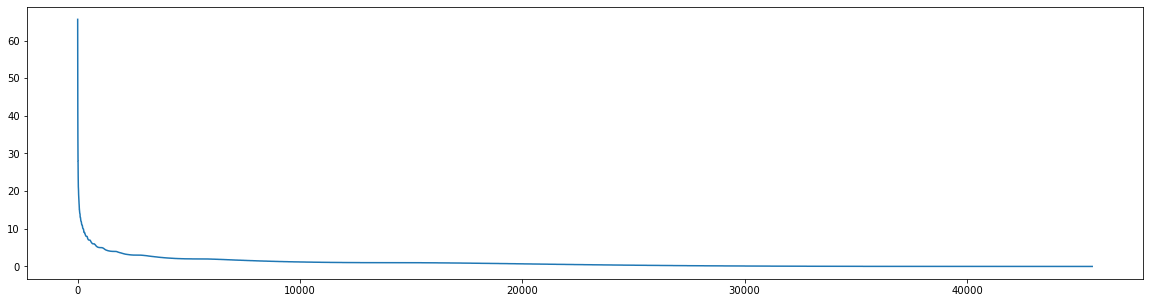

In [9]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(track_popularity.index.values, track_popularity["time"].values)

# ax.set_xscale("log")
# ax.set_yscale("log")

pass

## Compute offline metrics

In [11]:
# recommendations - список рекомендованных track id от лучшего к худшему
# track           - id трека, который выбрал пользователь
# k               - k в precision@K


def precision_at(recommendations, track, k):  # track - трек который понравился пользователю (понравился если время прослушивания более 0.75)
    return 1.0 / k * int(track in recommendations[:k])


    
def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)

In [12]:
tracks = track_popularity["track"].tolist()

t_p_10 = lambda track: precision_at(tracks, track, 10)
st_10_p_10 = lambda track: shuffled_precision_at(tracks[:10], track, 10)
st_100_p_10 = lambda track: shuffled_precision_at(tracks[:100], track, 10)
st_1000_p_10 = lambda track: shuffled_precision_at(tracks[:1000], track, 10)


metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["top10_PrecAt10"] = metrics["track"].map(t_p_10)
metrics["shuffledTop10_PrecAt10"] = metrics["track"].map(st_10_p_10)
metrics["shuffledTop100_PrecAt10"] = metrics["track"].map(st_100_p_10)
metrics["shuffledTop1000_PrecAt10"] = metrics["track"].map(st_1000_p_10)

metrics[["top10_PrecAt10", "shuffledTop10_PrecAt10", "shuffledTop100_PrecAt10", "shuffledTop1000_PrecAt10"]].describe()

,top10_PrecAt10,shuffledTop10_PrecAt10,shuffledTop100_PrecAt10,shuffledTop1000_PrecAt10
count,32929.000000,32929.000000,32929.000000,32929.000000
mean,0.001266,0.001266,0.000571,0.000182
std,0.011182,0.011182,0.007534,0.004265
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.100000,0.100000,0.100000,0.100000


top10 и shuffledtop10 совпали, что неудивительно

In [13]:
def mrr(recommendations, track):
    return 1.0 / (1 + recommendations.index(track)) if track in recommendations else 0.0

    
def shuffled_mrr(recommendations, track):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return mrr(shuffled, track)

In [14]:
tracks = track_popularity["track"].tolist()

t_mrr = lambda track: mrr(tracks, track)
st_10_mrr = lambda track: shuffled_mrr(tracks[:10], track)
st_100_mrr = lambda track: shuffled_mrr(tracks[:100], track)
st_1000_mrr = lambda track: shuffled_mrr(tracks[:1000], track)

metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["top10_mrr"] = metrics["track"].map(t_mrr)
metrics["shuffledTop10_mrr"] = metrics["track"].map(st_10_mrr)
metrics["shuffledTop100_mrr"] = metrics["track"].map(st_100_mrr)
metrics["shuffledTop1000_mrr"] = metrics["track"].map(st_1000_mrr)

metrics[["top10_mrr", "shuffledTop10_mrr", "shuffledTop100_mrr", "shuffledTop1000_mrr"]].describe()

,top10_mrr,shuffledTop10_mrr,shuffledTop100_mrr,shuffledTop1000_mrr
count,32929.000000,32929.000000,32929.000000,32929.000000
mean,0.005867,0.003732,0.002752,0.001382
std,0.046572,0.044358,0.028124,0.014003
min,0.000000,0.000000,0.000000,0.000000
25%,0.000039,0.000000,0.000000,0.000000
50%,0.000121,0.000000,0.000000,0.000000
75%,0.000685,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


## Export data for prod

In [21]:
with open("/Users/n.anokhin/Desktop/top_tracks.json", "w") as top_tracks_file:
    json.dump(track_popularity["track"].tolist(), top_tracks_file)